In [1]:
# Standard modules
import os
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from enum import Enum
from itertools import product
from typing import List, Literal

# Third-party libraries
import cudf
import joblib
import matplotlib.pyplot as plt
import networkx as nx
import nx_arangodb as nxadb
import pandas as pd
from arango import ArangoClient
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from tqdm import tqdm

# Langchain and Langgraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_community.graphs import ArangoGraph
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

[21:09:39 -0500] [INFO]: NetworkX-cuGraph is available.


In [2]:
load_dotenv()

# host, user, pass
password = os.getenv('ARANGODB_PASSWORD')
user = os.getenv('ARANGODB_USER')
hostname = os.getenv('ARANGODB_HOSTNAME')

Base schema

In [3]:
base_arquitecture = {
    "main_node": ["competence"],
    "nodes": [
        "skill",
        "knowledge",
        "attitude",
        "profession",
        "specialization_area",
        "industry",
        "experience_level",
        "responsibility_level",
        "organizational_culture",
        "action_plan"
        ],
    "edges": [
        # From competence to the 3 main factors: skill, knowledge and attitude
        {"source": "competence", "target": "skill", "edge_type": "contains"},
        {"source": "competence", "target": "knowledge", "edge_type": "requires"},
        {"source": "competence", "target": "attitude", "edge_type": "needs"},
        # Factors that cause variation in skill
        {"source": "responsibility_level", "target": "skill", "edge_type": "determines"},
        {"source": "profession", "target": "skill", "edge_type": "relevant_for"},
        # Factors that cause variation in knowledge
        {"source": "specialization_area", "target": "knowledge", "edge_type": "influences"},
        {"source": "industry", "target": "knowledge", "edge_type": "relevant_for"},
        # Factors that cause variation in attitude
        {"source": "organizational_culture", "target": "attitude", "edge_type": "influences"},
        {"source": "experience_level", "target": "attitude", "edge_type": "shapes"},
        # Concrete actions from skill, knowledge and attitude
        {"source": "knowledge", "target": "action_plan", "edge_type": "guides"},
        {"source": "attitude", "target": "action_plan", "edge_type": "guides"},
        {"source": "skill", "target": "action_plan", "edge_type": "reinforces"},
        # Final result
        {"source": "action_plan", "target": "competence", "edge_type": "develops"}
    ]
}

Visualization

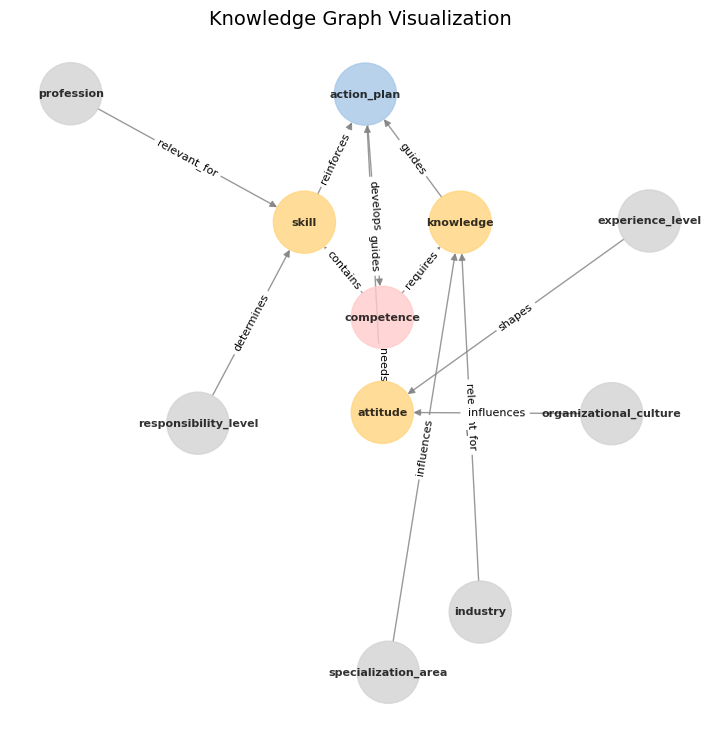

In [ ]:
G = nx.DiGraph()

for node in base_arquitecture["main_node"] + base_arquitecture["nodes"]:
    G.add_node(node)

edges_with_labels = {}
for edge in base_arquitecture["edges"]:
    G.add_edge(edge["source"], edge["target"])
    edges_with_labels[(edge["source"], edge["target"])] = edge["edge_type"]

plt.figure(figsize=(7, 7))

pos = nx.spring_layout(G)
pos["competence"] = (0, 0)
pos["skill"] = (-0.25, 0.25)
pos["knowledge"] = (0.25, 0.25)
pos["attitude"] = (0, -0.25)

node_colors = [
    "#FFCCCB" if node == "competence" else
    "#FFD580" if node in ["skill", "knowledge", "attitude"] else
    "#A7C7E7" if node == "action_plan" else
    "lightgray" for node in G.nodes
    ]

nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray",
        node_size=2000, font_size=8, font_weight="bold", arrows=True, alpha=0.8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_with_labels, font_size=8)

plt.title("Knowledge Graph Visualization", fontsize=14)
plt.show()


Factor Enums

In [ ]:
def enum_to_list(enum_class, category):
    return [
        {"id": member.name, "node_name": member.value, "node_category": category}
        for member in enum_class
        ]

# Based on Project Tuning framework https://tuningacademy.org/competences/generic-competences-tuning-la-i-and-ii/
class Competence(str, Enum):
    CMP_01 = "Capacity for abstraction, analysis, and synthesis"
    CMP_02 = "Ability to apply knowledge in practice"
    CMP_03 = "Ability to organise and plan time"
    CMP_04 = "Knowledge regarding the area of study and related professions"
    CMP_05 = "Social responsibility and commitment to citizenship"
    CMP_06 = "Capacity for oral and written communication"
    CMP_07 = "Ability to communicate in a second language"
    CMP_08 = "Ability to use information and communication technology"
    CMP_09 = "Capacity for investigation"
    CMP_10 = "Ability to learn and update learning"
    CMP_11 = "Ability to search for, process, and analyse information from a variety of sources"
    CMP_12 = "Critical and self-critical abilities"
    CMP_13 = "Ability to react to new situations"
    CMP_14 = "Creative skills"
    CMP_15 = "Ability to identify, pose, and solve problems"
    CMP_16 = "Ability to make decisions"
    CMP_17 = "Ability to work as part of a team"
    CMP_18 = "Interpersonal skills"
    CMP_19 = "Ability to motivate and work towards common goals"
    CMP_20 = "Commitment to look after the environment"
    CMP_21 = "Commitment to socio-cultural environment"
    CMP_22 = "Value and respect for diversity and multiculturality"
    CMP_23 = "Ability to work in international contexts"
    CMP_24 = "Ability to work autonomously"
    CMP_25 = "Ability to formulate and manage projects"
    CMP_26 = "Ethical commitment"
    CMP_27 = "Commitment to quality"

class Industry(str, Enum):
    IND_01 = "Technology/IT"
    IND_02 = "Healthcare"
    IND_03 = "Finance/Banking"
    IND_04 = "Manufacturing"
    IND_05 = "Retail/Consumer Goods"
    IND_06 = "Energy/Utilities"
    IND_07 = "Telecommunications"
    IND_08 = "Transportation/Logistics"
    IND_09 = "Education"
    IND_10 = "Government/Public Sector"
    IND_11 = "Hospitality/Tourism"
    IND_12 = "Real Estate/Construction"
    IND_13 = "Media/Entertainment"

class ResponsibilityLevel(Enum):
    RSP_01 = "Operational"
    RSP_02 = "Tactical"
    RSP_03 = "Strategic"

class Profession(Enum):
    PRF_01 = "Engineering"
    PRF_02 = "Medicine"
    PRF_03 = "Finance"
    PRF_04 = "Marketing"
    PRF_05 = "Sales"
    PRF_06 = "Human Resources"
    PRF_07 = "Technology"
    PRF_08 = "Education"
    PRF_09 = "Legal"
    PRF_10 = "Consulting"
    PRF_11 = "Construction"
    PRF_12 = "Design"
    PRF_13 = "Hospitality"
    PRF_14 = "Science & Research"
    PRF_15 = "Supply Chain & Logistics"
    PRF_16 = "Public Administration"
    PRF_17 = "Journalism & Media"
    PRF_18 = "Customer Service"

class ExperienceLevel(Enum):
    EXP_01 = "Entry Level"
    EXP_02 = "Mid Level"
    EXP_03 = "Senior Level"
    EXP_04 = "Executive"

class SpecializationArea(Enum):
    SPC_01 = "Mechanical Engineering"
    SPC_02 = "Electrical Engineering"
    SPC_03 = "Industrial Engineering"
    SPC_04 = "Robotics"
    SPC_05 = "General Practice"
    SPC_06 = "Cardiology"
    SPC_07 = "Orthopedics"
    SPC_08 = "Pulmonology"
    SPC_09 = "Surgery"
    SPC_10 = "Psychology"
    SPC_11 = "Laboratory Analysis"
    SPC_12 = "Accounting"
    SPC_13 = "Risk Management"
    SPC_14 = "Taxation"
    SPC_15 = "Auditing"
    SPC_16 = "Digital Marketing"
    SPC_17 = "Brand Management"
    SPC_18 = "Market Research"
    SPC_19 = "Advertising"
    SPC_20 = "Public Relations"
    SPC_21 = "Influencer Marketing"
    SPC_22 = "B2B Sales"
    SPC_23 = "B2C Sales"
    SPC_24 = "Key Account Management"
    SPC_25 = "Recruitment"
    SPC_26 = "Talent Management"
    SPC_27 = "Organizational Development"
    SPC_28 = "Workplace Safety"
    SPC_29 = "Software Development"
    SPC_30 = "Data Science"
    SPC_31 = "Cybersecurity"
    SPC_32 = "Cloud Computing"
    SPC_33 = "Database Administration"
    SPC_34 = "Artificial Intelligence & Machine Learning"
    SPC_35 = "IT Support"
    SPC_36 = "Web Development"
    SPC_37 = "School Education"
    SPC_38 = "Higher Education"
    SPC_39 = "Special Education"
    SPC_40 = "Online Education"
    SPC_41 = "Corporate Law"
    SPC_42 = "Criminal Law"
    SPC_43 = "Family Law"
    SPC_44 = "Business Strategy"
    SPC_45 = "Project Management"
    SPC_46 = "Operations Consulting"
    SPC_47 = "Supply Chain"
    SPC_48 = "Procurement"
    SPC_49 = "Architecture"
    SPC_50 = "Urban Planning"
    SPC_51 = "Construction"
    SPC_52 = "Electrical Installation"
    SPC_53 = "Policy Analysis"
    SPC_54 = "Social Services"
    SPC_55 = "Transportation Planning"

class OrganizationalCulture(Enum):
    ORG_01 = "Innovative"
    ORG_02 = "Customer-Centric"
    ORG_03 = "Collaborative"
    ORG_04 = "Inclusive"
    ORG_05 = "Ethical"
    ORG_06 = "Flexible"
    ORG_07 = "Learning-Oriented"
    ORG_08 = "Performance-Oriented"
    ORG_09 = "Employee-Centric"
    ORG_10 = "Purpose-Driven"
    ORG_11 = "Competitive"
    ORG_12 = "Risk-Taking"
    ORG_13 = "Community-Oriented"
    ORG_14 = "Sustainability-Focused"
    ORG_15 = "Data-Driven"
    ORG_16 = "Fast-Paced"
    ORG_17 = "Entrepreneurial"
    ORG_18 = "Trust-Based"

In [ ]:
competence_nodes = enum_to_list(Competence, "competence")
industry_nodes = enum_to_list(Industry, "industry")
responsibility_level_nodes = enum_to_list(ResponsibilityLevel, "responsibility_level")
profession_nodes = enum_to_list(Profession, "profession")
experience_level_nodes = enum_to_list(ExperienceLevel, "experience_level")
specialization_area_nodes = enum_to_list(SpecializationArea, "specialization_area")
organizational_culture_nodes = enum_to_list(OrganizationalCulture, "organizational_culture")

In [5]:
llm = ChatOpenAI(
    api_key=os.getenv('OPENAI_API_KEY'),
    model="gpt-4o-mini",
    temperature=0
)

In [6]:
# Classes

class Activity(BaseModel):

    name: str = Field(description="Name of the activity")
    weight: float = Field(description="Weight or relative importance to the competence that is aiming to improve")
    duration: int = Field(description="Estimated duration to accomplish the activity (in days)")

class NodeDetail(BaseModel):

    node_name: str = Field(
        description="Name of the node"
    )
    action_plan: List[Activity] = Field(
        description="Given a node name and previous conditions, add a list of activities."
    )

class NodeGenerator(BaseModel):
    node_type: Literal["skill", "knowledge", "attitude"] = Field(
        description="Type of node"
    )
    node_detail: List[NodeDetail] = Field(
        description="Given a competency and certain conditions, add a list of node details."
    )

# Prompt

base_system_prompt = """
    You are an expert in professional development and competency-based workforce planning.
    Your role is to generate structured development plans tailored to specific conditions.

    You will be asked to generate a structured plan of actionable activities based on a list of: {node}
    Each {node} if affected by conditions such as: {node_predecessor_text}.

    Instructions
    - node_type: Insert {node}.
    - node_detail: Create a list of exact 8 key {node} relevant to the provided competency, profession, and responsibility level.
      Each {node} represents a crucial area of expertise necessary for professional growth.

    Each {node} must contain:
    - node_name: The name of the {node}, directly linked to the given context. It should be precise and relevant.
    - action_plan: A structured set of activities (exact 3 per {node}) designed to develop the corresponding {node} effectively.

    Each activity must contain:
    - name: A clear and concise title describing the specific learning or training action.
    - weight: A numerical value between 0.0 and 1.0, indicating the relative importance of this activity in {node} development. Higher values mean greater relevance.
    - duration: An estimated time frame required to complete the activity. This should reflect realistic effort based on standard learning methodologies.

    Guidelines for Generation
    - Ensure that the selected {node} is logically derived from {node_predecessor_text}.
    - Activities should be realistic, actionable, and measurable, ensuring they contribute meaningfully to {node} acquisition.
    - Use industry-specific terminology where applicable, maintaining consistency with professional development standards.
    - Keep the response structured, concise, and free of additional explanations or formatting beyond what is required.

    Strictly adhere to the specified format and constraints. Do not include extra commentary, footnotes, or explanatory text.
    Only generate the structured content based on the given parameters.
"""

skill_human_prompt = """
    Context:
    Competence: {competence}
    Profession: {profession}
    Responsibility Level: {responsibility_level}
"""

knowledge_human_prompt = """
    Context:
    Competence: {competence}
    Specialization area: {specialization_area}
    Industry: {industry}
"""

attitude_human_prompt = """
    Context:
    Competence: {competence}
    Organizational culture: {organizational_culture}
    Experience level: {experience_level}
"""

def generate_prompt(node_focus, system_prompt, human_prompt):

    node_predecessor = [node['source'] for node in base_arquitecture['edges'] if node['target']==node_focus]
    node_predecessor_text = ', '.join(node_predecessor)

    completed_prompt = ChatPromptTemplate(
        [
            ("system", system_prompt),
            ("human", human_prompt)
        ]
    ).partial(
        node=node_focus,
        node_predecessor_text=node_predecessor_text)

    return completed_prompt

structured_llm = llm.with_structured_output(NodeGenerator)

skill_prompt = generate_prompt('skill', base_system_prompt, skill_human_prompt)
skill_chain = skill_prompt | structured_llm

knowledge_prompt = generate_prompt('knowledge', base_system_prompt, knowledge_human_prompt)
knowledge_chain = knowledge_prompt | structured_llm

attitude_prompt = generate_prompt('attitude', base_system_prompt, attitude_human_prompt)
attitude_chain = attitude_prompt | structured_llm

def get_edge_type(source_category, target_category, base_arquitecture):

    edge_type = [
        edge['edge_type']
        for edge in base_arquitecture['edges']
        if edge["source"] == source_category
        and edge["target"] == target_category
    ]

    return edge_type[0]

Skills generator

In [ ]:
# SKILLS

# Factors
# 27 competences
# 18 profession
# 3 responsibility levels

# Stats
# Tokens usage: 988,377
# Cost: $0.64

skill_edges = []
skill_nodes = []

def skill_combination(c, p, r):
    prefix = f"{c['id']}_{p['id']}_{r['id']}_"

    response = skill_chain.invoke({
        "competence": c['node_name'],
        "profession": p['node_name'],
        "responsibility_level": r['node_name']
    })

    edges = []
    nodes = []

    for seq, element in enumerate(response.node_detail):
        skill_suffix = f"SKL_{seq+1}"

        nodes.append({
            'id': prefix + skill_suffix,
            'node_name': element.node_name,
            'node_category': response.node_type
        })

        # Edges from factors to skills
        for val in [c, p, r]:
            edges.append({
                "source": val['id'],
                "target": prefix + skill_suffix,
                "edge_type": get_edge_type(val['node_category'], response.node_type, base_arquitecture)
            })

        for seq, action_plan in enumerate(element.action_plan):
            action_suffix = f"ACT_{seq+1}"

            nodes.append({
                'id': prefix + skill_suffix + '_' + action_suffix,
                'node_name': action_plan.name,
                'node_category': 'action_plan',
                'duration': action_plan.duration,
            })

            # Edges from skills to action_plans
            edges.append({
                "source": prefix + skill_suffix,
                "target": prefix + skill_suffix + '_' + action_suffix,
                "edge_type": get_edge_type(response.node_type, 'action_plan', base_arquitecture),
            })

            # Edges from action_plans to competences
            edges.append({
                "source": prefix + skill_suffix + '_' + action_suffix,
                "target": c['id'],
                "edge_type": get_edge_type('action_plan', c['node_category'], base_arquitecture),
                "weight": action_plan.weight
            })

    return nodes, edges

combinations = list(product(competence_nodes, profession_nodes, responsibility_level_nodes))

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(skill_combination, c, p, r): (c, p, r) for c, p, r in combinations}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing", unit="task"):
        nodes, edges = future.result()
        skill_nodes.extend(nodes)
        skill_edges.extend(edges)

Processing: 100%|██████████| 1458/1458 [51:13<00:00,  2.11s/task]


In [ ]:
joblib.dump(skill_nodes, "skill_nodes.pkl", compress=3)
joblib.dump(skill_edges, "skill_edges.pkl", compress=3)

Knowledge generator

In [ ]:
# KNOWLEDGE

# Factors
# 27 competences
# 58 specialization areas
# 13 industries

# Stats
# Tokens usage: 12,516,055
# Cost: $8.22

knowledge_edges = []
knowledge_nodes = []

def knowledge_combination(c, s, i):
    prefix = f"{c['id']}_{s['id']}_{i['id']}_"

    response = knowledge_chain.invoke({
        "competence": c['node_name'],
        "specialization_area": s['node_name'],
        "industry": i['node_name']
    })

    edges = []
    nodes = []

    for seq, element in enumerate(response.node_detail):
        knowledge_suffix = f"KNW_{seq+1}"

        nodes.append({
            'id': prefix + knowledge_suffix,
            'node_name': element.node_name,
            'node_category': response.node_type
        })

        # Edges from factors to knowledges
        for val in [c, s, i]:
            edges.append({
                "source": val['id'],
                "target": prefix + knowledge_suffix,
                "edge_type": get_edge_type(val['node_category'], response.node_type, base_arquitecture)
            })

        for seq, action_plan in enumerate(element.action_plan):
            action_suffix = f"ACT_{seq+1}"

            nodes.append({
                'id': prefix + knowledge_suffix + '_' + action_suffix,
                'node_name': action_plan.name,
                'node_category': 'action_plan',
                'duration': action_plan.duration,
            })

            # Edges from knowledges to action_plans
            edges.append({
                "source": prefix + knowledge_suffix,
                "target": prefix + knowledge_suffix + '_' + action_suffix,
                "edge_type": get_edge_type(response.node_type, 'action_plan', base_arquitecture),
            })

            # Edges from action_plans to competences
            edges.append({
                "source": prefix + knowledge_suffix + '_' + action_suffix,
                "target": c['id'],
                "edge_type": get_edge_type('action_plan', c['node_category'], base_arquitecture),
                "weight": action_plan.weight
            })

    return nodes, edges

combinations = list(product(competence_nodes, specialization_area_nodes, industry_nodes))

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(knowledge_combination, c, s, i): (c, s, i) for c, s, i in combinations}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing", unit="task"):
        nodes, edges = future.result()
        knowledge_nodes.extend(nodes)
        knowledge_edges.extend(edges)

Processing: 100%|██████████| 19305/19305 [03:11:08<00:00,  1.68task/s]


In [ ]:
joblib.dump(knowledge_nodes, "knowledge_nodes.pkl", compress=3)
joblib.dump(knowledge_edges, "knowledge_edges.pkl", compress=3)

Attitude generator

In [ ]:
# ATTITUDE

# Factors
# 27 competences
# 18 organizational culture
# 4 experience levels

# Stats
# Tokens usage: 1,320,818
# Cost: $0.88

attitude_edges = []
attitude_nodes = []

def attitude_combination(c, o, e):
    prefix = f"{c['id']}_{o['id']}_{e['id']}_"

    response = attitude_chain.invoke({
        "competence": c['node_name'],
        "organizational_culture": o['node_name'],
        "experience_level": e['node_name']
    })

    edges = []
    nodes = []

    for seq, element in enumerate(response.node_detail):
        attitude_suffix = f"ATT_{seq+1}"

        nodes.append({
            'id': prefix + attitude_suffix,
            'node_name': element.node_name,
            'node_category': response.node_type
        })

        # Edges from factors to attitudes
        for val in [c, o, e]:
            edges.append({
                "source": val['id'],
                "target": prefix + attitude_suffix,
                "edge_type": get_edge_type(val['node_category'], response.node_type, base_arquitecture)
            })

        for seq, action_plan in enumerate(element.action_plan):
            action_suffix = f"ACT_{seq+1}"

            nodes.append({
                'id': prefix + attitude_suffix + '_' + action_suffix,
                'node_name': action_plan.name,
                'node_category': 'action_plan',
                'duration': action_plan.duration,
            })

            # Edges from attitudes to action_plans
            edges.append({
                "source": prefix + attitude_suffix,
                "target": prefix + attitude_suffix + '_' + action_suffix,
                "edge_type": get_edge_type(response.node_type, 'action_plan', base_arquitecture),
            })

            # Edges from action_plans to competences
            edges.append({
                "source": prefix + attitude_suffix + '_' + action_suffix,
                "target": c['id'],
                "edge_type": get_edge_type('action_plan', c['node_category'], base_arquitecture),
                "weight": action_plan.weight
            })

    return nodes, edges

combinations = list(product(competence_nodes, organizational_culture_nodes, experience_level_nodes))

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(attitude_combination, c, o, e): (c, o, e) for c, o, e in combinations}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing", unit="task"):
        nodes, edges = future.result()
        attitude_nodes.extend(nodes)
        attitude_edges.extend(edges)

Processing: 100%|██████████| 1944/1944 [49:42<00:00,  1.53s/task]


In [ ]:
joblib.dump(attitude_nodes, "attitude_nodes.pkl", compress=3)
joblib.dump(attitude_edges, "attitude_edges.pkl", compress=3)

Homologate nodes and edges

In [15]:
# Load data
skill_nodes = joblib.load('skill_nodes.pkl')
skill_edges = joblib.load('skill_edges.pkl')
knowledge_nodes = joblib.load('knowledge_nodes.pkl')
knowledge_edges = joblib.load('knowledge_edges.pkl')
attitude_nodes = joblib.load('attitude_nodes.pkl')
attitude_edges = joblib.load('attitude_edges.pkl')

total_nodes = skill_nodes + knowledge_nodes + attitude_nodes
total_edges = skill_edges + knowledge_edges + attitude_edges
nodes_df = pd.DataFrame(total_nodes)
edges_df = pd.DataFrame(total_edges)

In [52]:
# Data manipulation on nodes

# Driver nodes

driver_nodes = nodes_df[nodes_df['node_category'] != "action_plan"].copy()
driver_nodes = cudf.DataFrame(driver_nodes)
driver_nodes = driver_nodes.drop(columns=['duration']).rename(columns={'id': 'old_id'})

driver_category_list = (
    driver_nodes
    .sort_values(['node_name','node_category'], ascending=[True,True])
    .groupby('node_name')['node_category']
    .unique()
    .reset_index()
)

first_driver_name = (
    driver_nodes
    .groupby('node_name')['old_id']
    .first()
    .reset_index(name='id')
)

driver_nodes = (
    driver_nodes
    .drop(columns=['node_category'])
    .merge(
        driver_category_list,
        on='node_name',
        how='left'
    )
    .merge(
        first_driver_name,
        on='node_name',
        how='left'
    )
)

driver_nodes_id_rename = driver_nodes[['old_id','id']]

driver_nodes = (
    driver_nodes
    [['id', 'node_name', 'node_category']]
    .drop_duplicates()
)

# Data manipulation on nodes

# Action plan nodes

action_plan_nodes = nodes_df[nodes_df['node_category'] == "action_plan"].copy()
action_plan_nodes = cudf.DataFrame(action_plan_nodes)
action_plan_nodes = action_plan_nodes.rename(columns={'id': 'old_id'})

median_duration = (
    action_plan_nodes
    .groupby('node_name')['duration']
    .median()
    .reset_index(name='median_duration')
)

first_action_plan_name = (
    action_plan_nodes
    .groupby('node_name')['old_id']
    .first()
    .reset_index(name='id')
)

action_plan_nodes = (
    action_plan_nodes
    .merge(
        median_duration,
        on='node_name',
        how='left'
    )
    .merge(
        first_action_plan_name,
        on='node_name',
        how='left'
    )
)

action_plan_nodes_id_rename = action_plan_nodes[['old_id','id']]

action_plan_nodes = (
    action_plan_nodes
    [['id', 'node_name', 'node_category', 'median_duration']]
    .rename(columns={'median_duration':'duration'})
    .drop_duplicates(subset=['id', 'node_name'], keep='first')
)

action_plan_nodes['node_category'] = (
    action_plan_nodes['node_category']
    .to_pandas()
    .map(lambda x: [x])
)

In [53]:
# Data manipulation on edges

# Edges
edges_df = cudf.DataFrame(edges_df)

factor_to_driver = list(set([
    edge['edge_type']
    for edge in base_arquitecture['edges']
    if edge['target'] in ['skill','knowledge','attitude']
    ]))

driver_to_action_plan = list(set([
    edge['edge_type']
    for edge in base_arquitecture['edges']
    if edge['target'] in ['action_plan']
    ]))

action_plan_to_competence = list(set([
    edge['edge_type']
    for edge in base_arquitecture['edges']
    if edge['target'] in ['competence']
    ]))

# Factors to Drivers
factor_to_driver_edges = edges_df[edges_df['edge_type'].isin(factor_to_driver)]

factor_to_driver_edges = (
    factor_to_driver_edges
    .rename(columns={'target':'old_target'})
    .merge(driver_nodes_id_rename, left_on='old_target', right_on='old_id')
    .rename(columns={'id':'target'})
    [['source','target','edge_type']]
    .drop_duplicates()
)

# Drivers to Action Plan
driver_to_action_plan_edges = edges_df[edges_df['edge_type'].isin(driver_to_action_plan)]

driver_to_action_plan_edges = (
    driver_to_action_plan_edges
    .rename(columns={'source':'old_source', 'target':'old_target'})
    .merge(driver_nodes_id_rename, left_on='old_source', right_on='old_id')
    .rename(columns={'id':'source'})
    .merge(action_plan_nodes_id_rename, left_on='old_target', right_on='old_id')
    .rename(columns={'id':'target'})
    [['source','target','edge_type']]
    .drop_duplicates()
)

# Action Plan to Competence
action_plan_to_competence_edges = edges_df[edges_df['edge_type'].isin(action_plan_to_competence)]

action_plan_to_competence_edges = (
    action_plan_to_competence_edges
    .rename(columns={'source':'old_source'})
    .merge(action_plan_nodes_id_rename, left_on='old_source', right_on='old_id')
    .rename(columns={'id':'source'})
    [['source','target','edge_type', 'weight']]
    .groupby(['source','target','edge_type'])
    .agg(weight=('weight','mean'))
    .reset_index()
)

In [54]:
# Adjust edges
factor_to_driver_edges = factor_to_driver_edges.to_dict(orient='records')
driver_to_action_plan_edges = driver_to_action_plan_edges.to_dict(orient='records')
action_plan_to_competence_edges = action_plan_to_competence_edges.to_dict(orient='records')

competence_to_driver_edges = [edge for edge in factor_to_driver_edges if edge['source'].startswith('CMP')]
factor_to_driver_edges = [edge for edge in factor_to_driver_edges if not edge['source'].startswith('CMP')]

In [55]:
def clean_nodes(nodes, is_dataframe=False):

    if is_dataframe:
        nodes = nodes.to_dict(orient='records')

    cleaned_nodes = []
    for node in nodes:
        cleaned_node = {'_key' if k == 'id' else k: v for k, v in node.items()}
        if isinstance(cleaned_node.get('node_category'), list):
            cleaned_node['node_category'] = ', '.join(cleaned_node['node_category'])
        cleaned_nodes.append(cleaned_node)

    return cleaned_nodes

def clean_edges(edges, source, target):
    cleaned_edges = []
    
    for edge in edges:
        cleaned_edge = {
            '_from' if k == 'source' else '_to' if k == 'target' else k: v
            for k, v in edge.items()
        }
        
        if '_from' in cleaned_edge:
            cleaned_edge['_from'] = f"{source}/{cleaned_edge['_from']}"
        if '_to' in cleaned_edge:
            cleaned_edge['_to'] = f"{target}/{cleaned_edge['_to']}"
        
        cleaned_edges.append(cleaned_edge)

    return cleaned_edges

In [56]:
# Final nodes
competence_nodes = clean_nodes(competence_nodes)
factor_nodes = (
    clean_nodes(industry_nodes) + clean_nodes(responsibility_level_nodes) +
    clean_nodes(profession_nodes) + clean_nodes(experience_level_nodes) +
    clean_nodes(specialization_area_nodes) + clean_nodes(organizational_culture_nodes)
)
driver_nodes = clean_nodes(driver_nodes, is_dataframe=True)
action_plan_nodes = clean_nodes(action_plan_nodes, is_dataframe=True)

# Final edges
competence_to_driver_edges = clean_edges(competence_to_driver_edges, 'Competence', 'Driver')
factor_to_driver_edges = clean_edges(factor_to_driver_edges, 'Factor', 'Driver')
driver_to_action_plan_edges = clean_edges(driver_to_action_plan_edges, 'Driver', 'Action_Plan')
action_plan_to_competence_edges = clean_edges(action_plan_to_competence_edges, 'Action_Plan', 'Competence')


Upload data into ArangoDB

In [7]:
client = ArangoClient(hosts=hostname)
sys_db = client.db("_system", username=user, password=password)
if not sys_db.has_database("work_db"):
    sys_db.create_database("work_db")
work_db = client.db("work_db", username=user, password=password)

In [13]:
GRAPH_NAME = "graph_mentor"
COLLECTIONS = {
    "nodes": [
        "Competence",
        "Factor",
        "Driver",
        "Action_Plan"
        ],
    "edges": [
        "Competence_to_Driver",
        "Factor_to_Driver",
        "Driver_to_Action_Plan",
        "Action_Plan_to_Competence"]
}

def create_collections(db):

    # For nodes
    for collection in COLLECTIONS["nodes"]:
        if not db.has_collection(collection):
            db.create_collection(collection)
            print(f"Created collection: {collection}")
            
            db.collection(collection).add_index({'type': 'hash', 'fields': ['node_category'], 'unique': False})
            db.collection(collection).add_index({'type': 'fulltext', 'fields': ['node_name']})

            if collection == "Action_Plan":
                db.collection(collection).add_index({'type': 'persistent', 'fields': ['duration'], 'sparse': False})

        else:
            print(f"Collection already exists: {collection}")
    
    # For edges
    for edge_collection in COLLECTIONS["edges"]:
        if not db.has_collection(edge_collection):
            db.create_collection(edge_collection, edge=True)
            print(f"Created edge collection: {edge_collection}")

            db.collection(edge_collection).add_index({'type': 'hash', 'fields': ['edge_type'], 'unique': False})

            if edge_collection == "Action_Plan_to_Competence":
                db.collection(edge_collection).add_index({'type': 'persistent', 'fields': ['weight'], 'sparse': False})

        else:
            print(f"Edge collection already exists: {edge_collection}")

def create_graph(db):
    if not db.has_graph(GRAPH_NAME):
        graph = db.create_graph(GRAPH_NAME)

        graph.create_edge_definition(
            edge_collection="Competence_to_Driver",
            from_vertex_collections=["Competence"],
            to_vertex_collections=["Driver"]
        )
        
        graph.create_edge_definition(
            edge_collection="Factor_to_Driver",
            from_vertex_collections=["Factor"],
            to_vertex_collections=["Driver"]
        )
        
        graph.create_edge_definition(
            edge_collection="Driver_to_Action_Plan",
            from_vertex_collections=["Driver"],
            to_vertex_collections=["Action_Plan"]
        )
        
        graph.create_edge_definition(
            edge_collection="Action_Plan_to_Competence",
            from_vertex_collections=["Action_Plan"],
            to_vertex_collections=["Competence"]
        )
        
        print(f"Created graph: {GRAPH_NAME}")
    else:
        print(f"Graph already exists: {GRAPH_NAME}")

create_collections(work_db)
create_graph(work_db)

Created collection: Competence
Created collection: Factor
Created collection: Driver
Created collection: Action_Plan
Created edge collection: Competence_to_Driver
Created edge collection: Factor_to_Driver
Created edge collection: Driver_to_Action_Plan
Created edge collection: Action_Plan_to_Competence
Created graph: graph_mentor


Upload data to ArangoDB

In [60]:
def insert_documents(db, collection_name, documents, batch_size=5000):
    if not documents:
        print(f"No documents to insert into {collection_name}")
        return
        
    collection = db.collection(collection_name)
    
    successful_inserts = 0
    for i in range(0, len(documents), batch_size):
        batch = documents[i:i+batch_size]
        try:
            result = collection.import_bulk(batch, on_duplicate="update")
            successful_inserts += result["created"] + result["updated"]
        except Exception as e:
            print(f"Error inserting batch into {collection_name}: {e}")
    
    print(f"Successfully inserted/updated {successful_inserts} documents in {collection_name}")

In [61]:
# Add nodes
insert_documents(work_db, "Competence", competence_nodes)
insert_documents(work_db, "Factor", factor_nodes)
insert_documents(work_db, "Driver", driver_nodes)
insert_documents(work_db, "Action_Plan", action_plan_nodes)

# Add edges
insert_documents(work_db, "Competence_to_Driver", competence_to_driver_edges)
insert_documents(work_db, "Factor_to_Driver", factor_to_driver_edges)
insert_documents(work_db, "Driver_to_Action_Plan", driver_to_action_plan_edges)
insert_documents(work_db, "Action_Plan_to_Competence", action_plan_to_competence_edges)

Successfully inserted/updated 27 documents in Competence
Successfully inserted/updated 111 documents in Factor
Successfully inserted/updated 29215 documents in Driver
Successfully inserted/updated 210989 documents in Action_Plan
Successfully inserted/updated 57497 documents in Competence_to_Driver
Successfully inserted/updated 129553 documents in Factor_to_Driver
Successfully inserted/updated 338866 documents in Driver_to_Action_Plan
Successfully inserted/updated 309983 documents in Action_Plan_to_Competence


Create views

In [ ]:
# View action_plan_competence_view

work_db.create_arangosearch_view(
    name='action_plan_competence_view',
    properties={
        "links": {
            "Action_Plan": {
                "analyzers": ["text_en"],
                "fields": {
                    "node_name": { "analyzers": ["text_en"] },
                    "duration": {}
                },
                "includeAllFields": False
            },
            "Action_Plan_to_Competence": {
                "fields": {
                    "weight": {}
                }
            },
            "Competence": {
                "fields": {
                    "node_name": { "analyzers": ["text_en"] }
                }
            }
        },
        "primarySort": [
            {"field": "weight", "direction": "desc"}
        ],
        "storedValues": [
            ["weight", "node_name"]
        ]
    }
)

{'global_id': 'h41794B8C8970/4693450',
 'id': '4693450',
 'name': 'action_plan_duration_view',
 'type': 'arangosearch',
 'cleanup_interval_step': 2,
 'commit_interval_msec': 1000,
 'consolidation_interval_msec': 1000,
 'consolidation_policy': {'type': 'tier',
  'segments_min': 1,
  'segments_max': 10,
  'segments_bytes_max': 5368709120,
  'segments_bytes_floor': 2097152,
  'min_score': 0},
 'primary_sort': [],
 'primary_sort_compression': 'lz4',
 'stored_values': [{'fields': ['duration'], 'compression': 'lz4'},
  {'fields': ['weight'], 'compression': 'lz4'}],
 'writebuffer_idle': 64,
 'writebuffer_active': 0,
 'writebuffer_max_size': 33554432,
 'links': {'Action_Plan': {'analyzers': ['text_en'],
   'fields': {'duration': {}},
   'includeAllFields': False,
   'storeValues': 'none',
   'trackListPositions': False},
  'Action_Plan_to_Competence': {'analyzers': ['identity'],
   'fields': {'weight': {}},
   'includeAllFields': False,
   'storeValues': 'none',
   'trackListPositions': False}

Create tools

In [ ]:
# Utils

def get_competences():
    aql = """
        FOR comp in Competence
        RETURN comp.node_name
    """

    cursor = work_db.aql.execute(aql)
    response = list(cursor)
    return response

@tool
def find_closest_competence(llm, query):
    
    class Selection(BaseModel):
        competence: Competence = Field(
            description="Given a text, clasify the closest competence",
        )

    system = """You are a classification system, given a user query assign the most similar competence"""
    structured_llm = llm.with_structured_output(Selection)

    prompt = ChatPromptTemplate.from_messages(
        [("system", system), ("human", "User query: {query}")]
    )

    chain = prompt | structured_llm
    response = chain.invoke({'query':query})
    return response.competence.value

In [32]:
@tool
def find_competences() -> dict:
    """
    This tool extracts competences when the user ask for them.
    """
    return get_competences()
    

@tool
def find_best_competences_for_action_plan(query: str):
    """
    This tool identifies the best competences being developed by a given action plan.
    It tokenizes the action plan text, searches for similar matching plans,
    joins them with their associated competences and returns the top 3 competences
    based on the average weight of the top 5 associated plans.
    """

    aql = """
    LET keywords = TOKENS(@user_text, 'text_en')

    // Filter candidates
    LET candidatePlans = (
      FOR plan IN action_plan_competence_view
        SEARCH ANALYZER(
          plan.node_name IN keywords,
          'text_en'
        )
        SORT BM25(plan) DESC
        LIMIT 20000
        RETURN plan
    )

    // Join candidates and competences
    LET candidateEdges = (
      FOR plan IN candidatePlans
        LET edge = FIRST(
          FOR e IN Action_Plan_to_Competence
            FILTER e._from == plan._id
            RETURN e
        )
        FILTER edge != null
        RETURN { plan, edge }
    )

    // Join competence to find node_name
    LET competenceCandidates = (
      FOR pair IN candidateEdges
        LET comp = DOCUMENT(pair.edge._to)
        RETURN {
          competence_id: comp._id,
          competence_name: comp.node_name,
          plan_id: pair.plan._id,
          plan_name: pair.plan.node_name,
          weight: pair.edge.weight
        }
    )

    // Groupby and get average weight, select top 5 plans per competence
    LET groupedByCompetence = (
      FOR cand IN competenceCandidates
        COLLECT comp_id = cand.competence_id, comp_name = cand.competence_name INTO plansArr = cand
        LET sortedPlans = (
          FOR p IN plansArr
            SORT p.weight DESC
            RETURN { plan_name: p.plan_name, weight: p.weight }
        )
        LET top5 = SLICE(sortedPlans, 0, 5)
        LET avg_weight = LENGTH(top5) > 0 ? AVERAGE(top5[*].weight) : 0
        RETURN {
          competence_name: comp_name,
          avg_weight,
          plans: top5
        }
    )

    // Rank and give top 3 developed competences
    LET ranked_competences = (
      FOR comp IN groupedByCompetence
        SORT comp.avg_weight DESC
        LIMIT 3
        RETURN comp
    )

    RETURN ranked_competences
    """

    cursor = work_db.aql.execute(aql, bind_vars={"user_text": query})
    response = list(cursor)

    return response
  
@tool
def suggest_action_plans_for_competence(query: str):
    """
    This tool suggests targeted action plans to improve a specific competence.
    When a user indicates a desire to enhance a competence or that they want to improve something very vaguely
    """
    
    select_competence = find_closest_competence(llm, query)

    aql = """
    LET targetCompetence = @competence
    LET keywords = TOKENS(targetCompetence, 'text_en')

    // Get ID of the Competence
    LET targetCompetenceKey = FIRST(
      FOR comp IN Competence
        FILTER comp.node_name == targetCompetence
        RETURN comp._key
    )

    // Find possible action plans for the competence
    LET candidatePlans = (
      FOR plan IN action_plan_competence_view
        SEARCH ANALYZER(
          plan.node_name IN keywords,
          'text_en'
        )
        FILTER plan.node_category == 'action_plan'
          AND STARTS_WITH(plan._key, targetCompetenceKey)
        SORT BM25(plan) DESC
        LIMIT 20000
        RETURN plan
    )

    LET relevantAPs = (
      FOR plan IN candidatePlans
        FOR ape IN Action_Plan_to_Competence
          FILTER ape._from == plan._id
          RETURN MERGE(plan, { weight: ape.weight })
    )

    // Find 3 for each of the drivers
    LET driverAPs = UNION(
      // 3 skills
      (
        FOR ap IN relevantAPs
          FOR da IN Driver_to_Action_Plan
            FILTER da._to == ap._id
            LET driver = DOCUMENT(da._from)
            FILTER driver.node_category == "skill"
            SORT RAND()
            LIMIT 3
            RETURN { driver, ap }
      ),
      // 3 knowledges
      (
        FOR ap IN relevantAPs
          FOR da IN Driver_to_Action_Plan
            FILTER da._to == ap._id
            LET driver = DOCUMENT(da._from)
            FILTER driver.node_category == "knowledge"
            SORT RAND()
            LIMIT 3
            RETURN { driver, ap }
      ),
      // 3 attitudes
      (
        FOR ap IN relevantAPs
          FOR da IN Driver_to_Action_Plan
            FILTER da._to == ap._id
            LET driver = DOCUMENT(da._from)
            FILTER driver.node_category == "attitude"
            SORT RAND()
            LIMIT 3
            RETURN { driver, ap }
      )
    )

    // Paso 5: Agrupar por driver y seleccionar los 2 planes con mayor weight
    LET groupedDrivers = (
      FOR item IN driverAPs
        COLLECT driver = item.driver INTO apGroup = item
        LET plans = apGroup[*].ap
        LET sortedPlans = (
          FOR plan IN plans
            SORT plan.weight DESC
            RETURN { plan_name: plan.node_name, weight: plan.weight }
        )
        LET top3Plans = SLICE(sortedPlans, 0, 3)
        RETURN { driver, action_plans: top3Plans }
    )

    RETURN groupedDrivers
    """

    cursor = work_db.aql.execute(aql, bind_vars={"competence": select_competence})
    response = list(cursor)
    return response

@tool
def best_action_plan_per_competence(query:str):
    """
    This tool is used when the user ask what is the best course of action or action plan or activity they can do
    in order to improve an specific competence
    """
    
    select_competence = find_closest_competence(llm, query)

    aql = """
    LET targetCompetence = @competence
    LET keywords = TOKENS(targetCompetence, 'text_en')
    LET targetCompetenceKey = FIRST(
      FOR comp IN Competence
        FILTER comp.node_name == targetCompetence
        RETURN comp._key
    )

    LET candidatePlans = (
      FOR plan IN action_plan_competence_view
      SEARCH ANALYZER(plan.node_name IN keywords, 'text_en')
      FILTER plan.node_category == 'action_plan'
        AND STARTS_WITH(plan._key, targetCompetenceKey)
      RETURN plan
    )

    // Join action plan and weight
    LET candidateEdges = (
      FOR plan IN candidatePlans
        LET edge = FIRST(
          FOR e IN Action_Plan_to_Competence
            FILTER e._from == plan._id
            RETURN e
        )
        FILTER edge != null
        RETURN { plan, weight: edge.weight }
    )

    // Select best action plan
    LET topPlan = (
      FOR cand IN candidateEdges
        SORT cand.weight DESC
        LIMIT 1
        RETURN {
          plan_name: cand.plan.node_name,
          weight: cand.weight
        }
    )

    RETURN topPlan
    """

    cursor = work_db.aql.execute(aql, bind_vars={"competence": select_competence})
    response = list(cursor)
    return response

@tool
def find_duration_action_plan(query: str):
    """
    This tool helps the user when they want to know how muchs days a
    course of action or action plan or activity can take
    """


    aql = """
    LET keywords = TOKENS(@user_text, 'text_en')

    LET candidatePlans = (
      FOR plan IN action_plan_competence_view
        SEARCH ANALYZER(
          plan.node_name IN keywords,
          'text_en'
        )
        SORT BM25(plan) DESC
        LIMIT 20
        RETURN plan
    )

    LET durations = (
      FOR plan IN candidatePlans
        RETURN plan.duration
    )

    RETURN { average_duration: AVERAGE(durations) }
    """

    cursor = work_db.aql.execute(aql, bind_vars={"user_text": query})
    response = list(cursor)
    return response

In [ ]:
G_growth = nxadb.DiGraph(
    name="graph_mentor",
    db=work_db
    )

arango_graph = ArangoGraph(work_db)

@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=False,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)
    return str(result["result"])

[21:38:35 -0500] [INFO]: Graph 'graph_mentor' exists.
[21:38:35 -0500] [INFO]: Default node type set to 'Action_Plan'


In [ ]:
# Create the Agent
def create_graph_rag_agent():
    """Create and return the GraphRAG agent"""
    tools = [
        find_competences,
        find_best_competences_for_action_plan,
        suggest_action_plans_for_competence,
        best_action_plan_per_competence,
        find_duration_action_plan,
        text_to_aql_to_text,
        find_closest_competence
    ]
    
    return create_react_agent(llm, tools)

# Function to query the agent
def query_graph_rag(query):
    """Query the GraphRAG agent with a user question"""
    agent = create_graph_rag_agent()
    final_state = agent.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [ ]:
response = query_graph_rag("How many total nodes are in the graph in all the collections?")

In [ ]:
user_questions = [
    'Which {action plans} will help me improve the {competence} I want to develop?',
    'How do {factors} relate to the recommended {action plans}?',
    'Which {drivers} are associated with the {competence} I want to develop?',
    'Which {action plan} has the highest weight (impact) on developing the {competence}?',
    'What is the average duration of the recommended {action plans} for my {competence}?',
    'Are there {action plans} that fit my {organizational style} or {internal culture}?',
    'What combination of {drivers} is enhanced by the suggested {action plans}?'
    'How do the {action plans} for different {competences} I’m interested in compare?',
    'How personalized are the {action plans} based on my profession or responsibility level?',
    'Can I see examples of successful {action plans} applied to others with similar {factors}?'
]

evaluator_questions = [
    'How effective are the recommended {action plans} in enhancing the targeted {competences}?',
    'What is the average impact score (weight) of the {action plans} linked to each {competence}',
    'Which {drivers} are most closely associated with successful competence development?',
    'How do personal {factors} influence the selection of {action plans} for my team?',
    'What is the typical duration of the {action plans}, and does it align with our development goals and timelines?',
    'Are there consistent patterns in the connectivity between {competences}, {drivers}, and {action plans} that indicate overall development success?',
]


[]